In [3]:
from pHcalc import Acid, Inert, System
import numpy as np
import matplotlib.pyplot as plt


a = b = c = d = np.linspace(0,1,20)
A, B, C, D = np.meshgrid(a,b,c,d)
g1 = np.vstack([I.ravel() for I in (A,B,C,D)]).T
E = np.array([1-np.sum(gi) for gi in g1]).reshape(-1,1)
grid = np.hstack([g1,E])
grid = grid[np.where(E>=0)[0],:]
grid.shape

def get_pH(x, base_conc, vtot = 1): 
    vs = []
    cs = []
    for ii,xi in enumerate(x):
        vs.append(xi*vtot)
        cs.append(vs[-1]*base_conc[ii]/vtot)
    
    components = [Acid(pKa=[2,16, 7.21, 12.32], charge=0, conc=cs[0]), # H3PO4
              Inert(charge=1, conc=cs[1]), # NaOH
              Acid(pKa=3.14, charge=0, conc=cs[2]), # HF
              Acid(pKa=[-3, 1.92], charge=1, conc=cs[3]), # H2SO4
              Inert(charge=-1, conc=cs[4])] # HCl
              
    system = System(*components)
    system.pHsolve()
    return(system.pH) # Should print

grid.shape

(8855, 5)

[0.5 0.5 0.1 0.1 0.2]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8855/8855 [00:34<00:00, 254.10it/s]


(array([4825., 1446.,  194.,   75.,  331.,  266.,   36.,   14.,  388.,
        1280.]),
 array([ 0.69896927,  1.99896912,  3.29896896,  4.59896881,  5.89896866,
         7.19896851,  8.49896835,  9.7989682 , 11.09896805, 12.3989679 ,
        13.69896774]),
 <BarContainer object of 10 artists>)

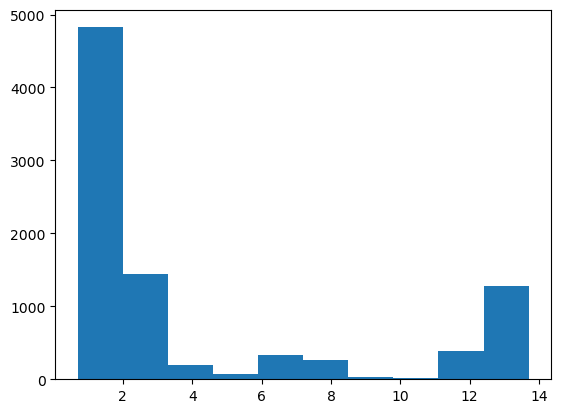

In [4]:
from tqdm import tqdm


np.random.seed(42)
base_conc = np.round(np.random.rand(5),2)
base_conc = np.array([0.5, 0.5, 0.1, 0.1,0.2]) #np.array([0.5, 0.5, 0.1, 0.1, 0.1, 0.1,0.1])
print(base_conc)
f = lambda x: get_pH(x, base_conc = base_conc)

pHs = np.array([f(xi) for xi in tqdm(grid)])
fig,ax = plt.subplots()
ax.hist(pHs)

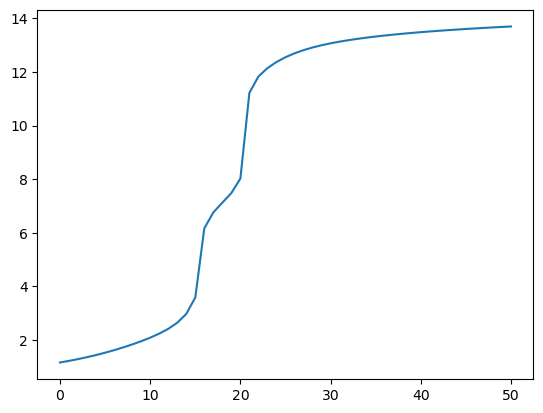

In [23]:
from dexpy.cox_effects import generate_cox_points

i = 1

refp = np.ones(5)*0.25
refp[i] = 0
vec = generate_cox_points(refp, i, 50)

fig,ax = plt.subplots()
ax.plot([f(vi) for vi in vec])

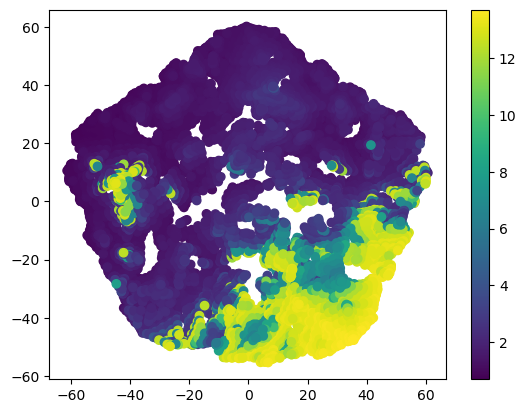

In [3]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(grid)
fig,ax = plt.subplots()
a = ax.scatter(*tsne.T, c=pHs)
plt.colorbar(a)

/home/frederic/miniconda3/envs/analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


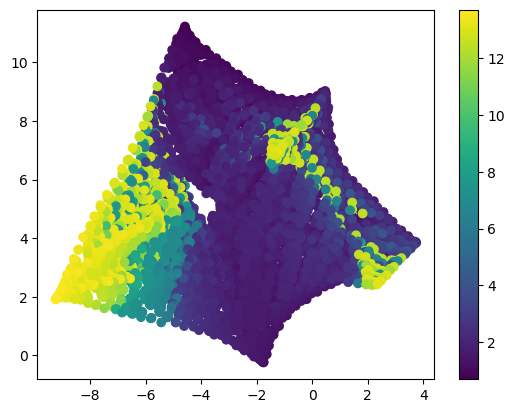

In [4]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(grid)
fig,ax = plt.subplots()
a = ax.scatter(*embedding[:,:2].T, c=pHs)
plt.colorbar(a)

In [5]:
f = lambda x: get_pH(x.ravel(), base_conc = base_conc)

def get_label(x):
    pH = f(x)
    if pH <= 4:
        return 0
    elif pH > 4 and pH < 10:
        return 1
    else:
        return 2

In [6]:
from borfr import BO_RFR, fps
import warnings
warnings.filterwarnings("ignore")

np.random.seed(5)

X_init = fps(grid,20)

y_init = np.array([f(xi) for xi in X_init])

x_test = fps(grid, 1000)

regm = 'RFC'
clm = 'RFC'

esl = 'AC'

n_iter = 200
nb = 1
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=1.5, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

rand_scores = []
for i in range(2):
    rand = BO_RFR(X_init, y_init, grid, f, x_test, 
                  acq='random',gl = get_label,  
                  est_labels=esl, N_batch=1,
                  class_method = clm, reg_method = regm)
    
    rand.run(n_iter)
    rand_scores.append(rand.scores)


sf = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm)

sf.run(n_iter)

gp = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm, gpr=True)

gp.run(n_iter)

generating test data


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 258.14it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [01:33<00:00,  2.15it/s]


generating test data


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 243.86it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [01:10<00:00,  2.85it/s]


generating test data


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 249.81it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [01:12<00:00,  2.75it/s]


generating test data


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 246.19it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [01:15<00:00,  2.66it/s]


generating test data


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 239.69it/s]


running iterative exploration:


100%|█████████████████████████████████████████| 200/200 [00:35<00:00,  5.70it/s]


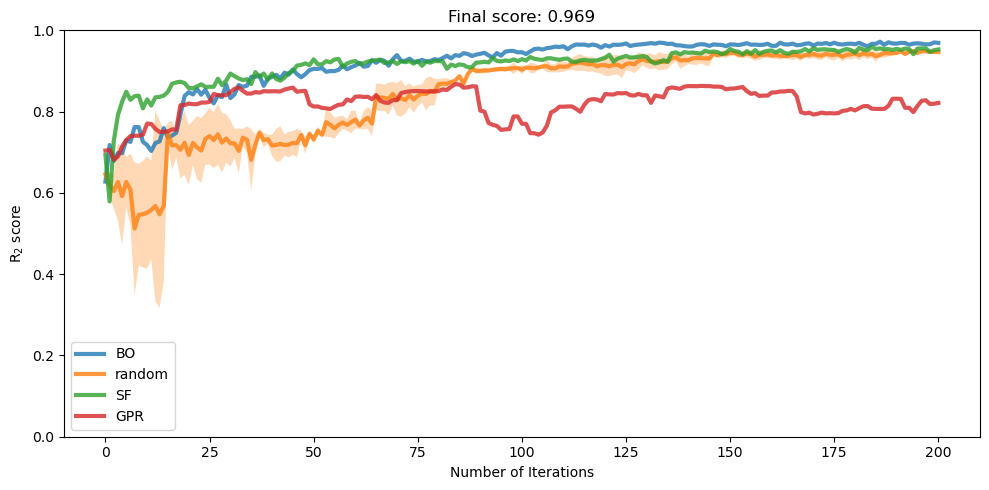

In [7]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
    ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                     np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

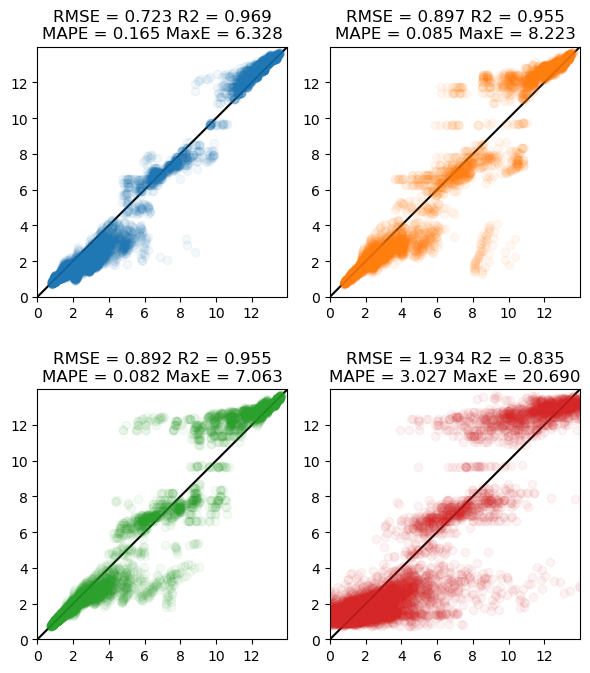

In [8]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, max_error
fig,axes = plt.subplots(ncols=2,nrows=2, figsize=(6,7))
mods = [bor, rand, sf, gp]
for ii,ax in enumerate(axes.ravel()):
    pred = mods[ii].model.predict(grid)
    #pred = mods[ii].reg_models[50].predict(grid)
    E = pred-pHs
    RMSE = np.sqrt(np.mean(E**2))
    r2 = r2_score(pred, pHs)
    mape = mean_absolute_percentage_error(pred, pHs)
    maxe = max_error(pred,pHs)
    ax.scatter(pred,pHs, alpha=0.05, c='C%i'%(ii))
    ax.set_title('RMSE = %.3f R2 = %.3f\nMAPE = %.3f MaxE = %.3f'%(RMSE, r2, mape,maxe))
    
    ax.plot((0,1),(0,1),c='k',zorder=-1, transform=ax.transAxes)
    ax.set_xticks(np.arange(0,14,2))
    ax.set_yticks(np.arange(0,14,2))
    ax.set_xlim(0,14)
    ax.set_ylim(0,14)
    ax.set_aspect('equal')
plt.tight_layout()

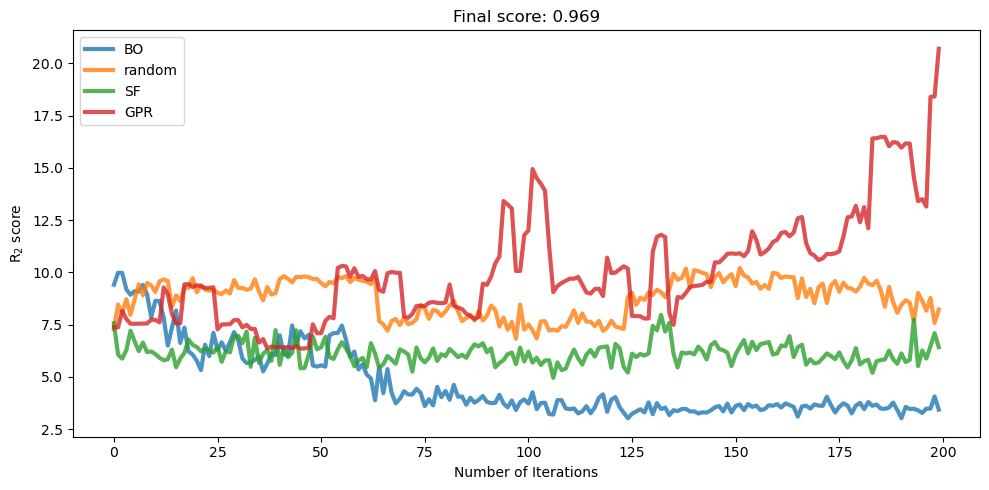

In [20]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

si = 0

ax2.plot(np.arange(bor.n_iters+1)*nb,np.array(bor.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.array(rand.all_scores)[:,si],lw=3,alpha=0.8, label='random')
    #ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
    #                 np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),np.array(sf.all_scores)[:,si],lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),np.array(gp.all_scores)[:,si],lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

In [9]:
for i in np.unique(bor.labels):
    print(np.mean(bor.y[bor.labels==i]),np.var(bor.y[bor.labels==i]))

5.216850703846323 6.243147203748804
12.138565859587295 0.3341364544872479
9.667196485731337 0.0013800324403599904


[0.14641148 0.26889952 0.19904306 0.2062201  0.17942584]
[0.06750572 0.36956522 0.19679634 0.20881007 0.15732265]
[0.09356725 0.3245614  0.24561404 0.23099415 0.10526316]


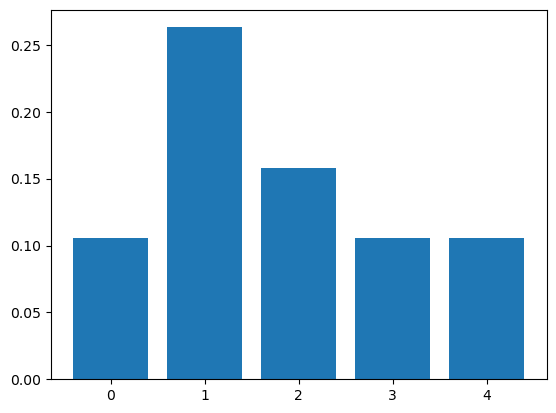

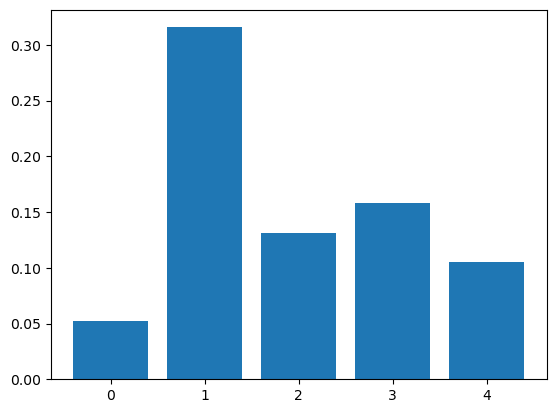

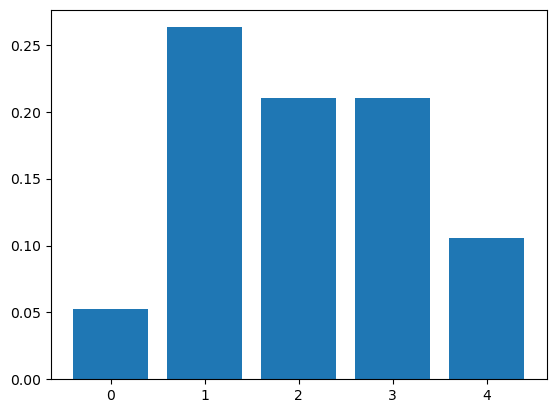

In [10]:
for i in np.unique(bor.labels):
    print(np.mean(bor.X[bor.labels==i],axis=0))
    fig,ax = plt.subplots()
    ax.bar(range(5),np.percentile(bor.X[bor.labels==i],50,axis=0))

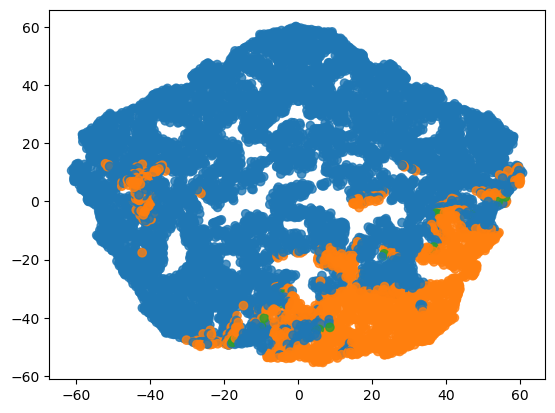

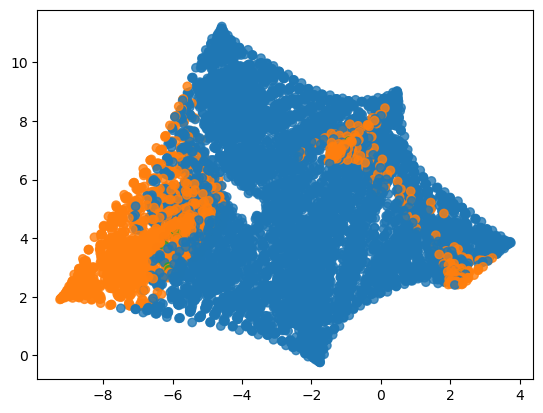

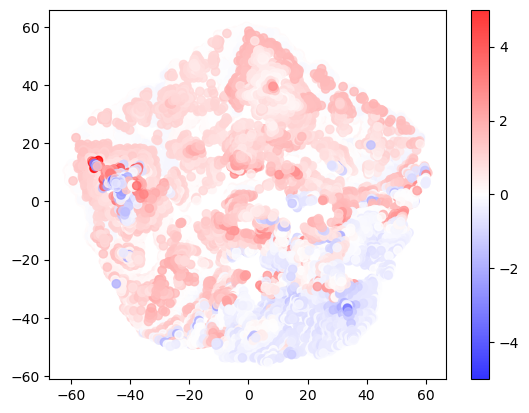

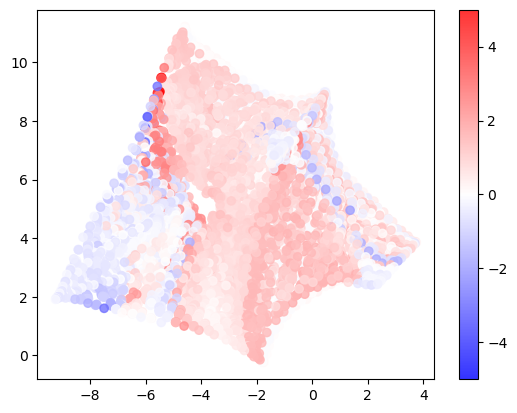

In [11]:
fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=bor.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=0.8)
fig,ax = plt.subplots()
ax.scatter(*embedding[:,:2].T, c=bor.classifier.predict(grid),cmap='tab10', vmin=0,vmax=10,alpha=0.8)

fig,ax = plt.subplots()
a = ax.scatter(*tsne.T, c=bor.model.predict(grid)-pHs,alpha=0.8, cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(a)
fig,ax = plt.subplots()
a = ax.scatter(*embedding[:,:2].T, c=bor.model.predict(grid)-pHs,alpha=0.8, cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(a)